In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("data/learning_data_5.csv")
df = df.drop(["Unnamed: 0", "FormDiff_01", "FormDiff_05", "FormDiff_066"], axis=1)

In [3]:
columns_to_select = df.columns[4:-1]
columns_to_select

Index(['FormDiff_033', 'L_k_Pts_Diff', 'L_k_St_A_Diff', 'L_k_Gls_A_Diff',
       'L_k_cor_A_Diff', 'L_k_Off_A_Diff', 'L_k_Poss_A_Diff', 'L_k_Fls_A_Diff',
       'Att_Diff', 'Mid_Diff', 'Def_Diff', 'Rat_Diff', 'Bud_Diff', 'Goal_Diff',
       'Pts_Diff', 'W_Pts_Diff', 'Accel_Diff', 'Stam_Diff', 'Str_Diff',
       'Balance_Diff', 'Sprint_Diff', 'Agility_Diff', 'Jumping_Diff',
       'Aggression_Diff', 'Reactions_Diff', 'Att._Position_Diff',
       'Interceptions_Diff', 'Vision_Diff', 'Ball_Ctrl_Diff', 'Dribbling_Diff',
       'Crossing_Diff', 'Short_Pass_Diff', 'Long_Pass_Diff', 'Heading_Diff',
       'Shot_Power_Diff', 'Finishing_Diff', 'Long_Shots_Diff', 'Curve_Diff',
       'FK_Acc._Diff', 'Penalties_Diff', 'Volleys_Diff'],
      dtype='object')

In [4]:
scaled_data = preprocessing.StandardScaler().fit_transform(df[columns_to_select])

In [5]:
scaled_df = pd.DataFrame(scaled_data, columns = columns_to_select)

In [6]:
scaled_df["Result"] = df["Result"]
scaled_df["Season"] = df["Season"]
scaled_df["Round"] = df["Round"]
scaled_df["Home"] = df["Home"]
scaled_df["Away"] = df["Away"]

#### Helper functions

In [7]:
def rps(predicted, observed):
    r = len(predicted)
    cum_predicted = np.cumsum(predicted)
    cum_observed = np.cumsum(observed)
    total_sum = 0
    for c_p, c_o in zip(cum_predicted, cum_observed):
        total_sum += (c_p - c_o) ** 2
    return total_sum / (r - 1) 

In [8]:
def convert_odds_to_prob(odds):
    return [1/odd for odd in odds]

In [9]:
def convert_to_vector(result):
    if result == "H":
        return [1, 0, 0]
    elif result == "D":
        return [0, 1, 0]
    return [0, 0, 1]

In [10]:
def confusion_matrix(test_y, y_pred):
    pred_h_act_h = sum([t == "H" and p == "H" for (t, p) in zip(test_y, y_pred)])
    pred_h_act_d = sum([t == "D" and p == "H" for (t, p) in zip(test_y, y_pred)]) 
    pred_h_act_a = sum([t == "A" and p == "H" for (t, p) in zip(test_y, y_pred)])
    
    pred_d_act_h = sum([t == "H" and p == "D" for (t, p) in zip(test_y, y_pred)])
    pred_d_act_d = sum([t == "D" and p == "D" for (t, p) in zip(test_y, y_pred)]) 
    pred_d_act_a = sum([t == "A" and p == "D" for (t, p) in zip(test_y, y_pred)]) 
    
    pred_a_act_h = sum([t == "H" and p == "A" for (t, p) in zip(test_y, y_pred)])
    pred_a_act_d = sum([t == "D" and p == "A" for (t, p) in zip(test_y, y_pred)]) 
    pred_a_act_a = sum([t == "A" and p == "A" for (t, p) in zip(test_y, y_pred)])
    
    return np.array([[pred_h_act_h, pred_d_act_h, pred_a_act_h],
                     [pred_h_act_d, pred_d_act_d, pred_a_act_d],
                     [pred_h_act_a, pred_d_act_a, pred_a_act_a]])

In [11]:
def precision_recall_table(confusion_matrix):
    accuracy = sum([confusion_matrix[i][i] for i in range(len(confusion_matrix))]) / np.sum(confusion_matrix)
    
    home_precision = confusion_matrix[0][0] / sum(confusion_matrix[:,0])
    draw_precision = confusion_matrix[1][1] / sum(confusion_matrix[:,1])
    away_precision = confusion_matrix[2][2] / sum(confusion_matrix[:,2])
    
    home_recall = confusion_matrix[0][0] / sum(confusion_matrix[0,:])
    draw_recall = confusion_matrix[1][1] / sum(confusion_matrix[1,:])
    away_recall = confusion_matrix[2][2] / sum(confusion_matrix[2,:])
    
    home_f1 = 2 * home_precision * home_recall / (home_precision + home_recall)
    draw_f1 = 2 * draw_precision * draw_recall / (draw_precision + draw_recall)
    away_f1 = 2 * away_precision * away_recall / (away_precision + away_recall)
    
    return accuracy, np.array([[home_precision, home_recall, home_f1],
                               [draw_precision, draw_recall, draw_f1],
                               [away_precision, away_recall, away_f1]])

## Predictive modeling

In [18]:
season = "2018/2019"

### Logistic Regression

In [207]:
clf = LogisticRegression(C=0.015, max_iter=100)

learning_set = scaled_df.loc[scaled_df["Season"] != season]
testing_set = scaled_df.loc[scaled_df["Season"] == season]

train_X, train_y = learning_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), learning_set["Result"]
test_X, test_y = testing_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), testing_set["Result"]

clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
y_proba = clf.predict_proba(test_X)

rps_list = [rps(y_pro[::-1], convert_to_vector(y_t)) for y_pro, y_t in zip(y_proba, test_y)]
log_reg_model_rps = (sum(rps_list) / len(y_pred))
log_reg_rps_df = pd.DataFrame.from_dict({'RPS': rps_list, 'Round': testing_set["Round"]})

rps_avgs_lr = []
rnds = list(range(6, 35))
for rnd in rnds:
    rps_values = list(log_reg_rps_df.loc[log_reg_rps_df["Round"] == rnd, "RPS"].values)
    avg = sum(rps_values) / len(rps_values)
    rps_avgs_lr.append(avg)
log_res_rps = sum(rps_avgs_lr) / len(rps_avgs_lr)

print("RPS: ", log_reg_model_rps)
conf = confusion_matrix(test_y, y_pred)
print(conf)
log_res_acc, pr_re_table = precision_recall_table(conf)
print("Accuracy: ", log_res_acc)
print(pr_re_table)

RPS:  0.19044622016066648
[[97  0 20]
 [41  3 16]
 [31  2 51]]
Accuracy:  0.578544061302682
[[0.5739645  0.82905983 0.67832168]
 [0.6        0.05       0.09230769]
 [0.5862069  0.60714286 0.59649123]]


### Random Forest

In [132]:
iterations = 50
acc_list_rf = []
rps_list_rf = []
pr_re_table_sum = np.zeros((3, 3))
for i in range(iterations):
    clf = RandomForestClassifier(n_estimators=1000, max_depth=200, criterion="gini")
    learning_set = df.loc[df["Season"] != season]
    testing_set = df.loc[df["Season"] == season]

    train_X, train_y = learning_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), learning_set["Result"]
    test_X, test_y = testing_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), testing_set["Result"]

    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    y_proba = clf.predict_proba(test_X)

    rf_model_rps = (sum([rps(y_pro[::-1], convert_to_vector(y_t)) for y_pro, y_t in zip(y_proba, test_y)]) / len(y_pred))
    rps_list_rf.append(rf_model_rps)
    
    conf = confusion_matrix(test_y, y_pred)
    rf_acc, pr_re_table = precision_recall_table(conf)
    
    pr_re_table_sum = np.add(pr_re_table_sum, pr_re_table)
    acc_list_rf.append(rf_acc)
    
rps_avg_rf = sum(rps_list_rf) / iterations
acc_avg_rf = sum(acc_list_rf) / iterations
pr_re_table_avg = np.true_divide(pr_re_table_sum, iterations)

print(rps_avg_rf)
print(acc_avg_rf)
print(pr_re_table_avg)

0.1912401707279694
0.587509578544061
[[0.5850697  0.8642735  0.69774601]
 [0.71       0.02966667 0.05660236]
 [0.59087818 0.60047619 0.59550954]]


### Gradient Boosting

In [133]:
iterations = 50
acc_list_gb = []
rps_list_gb = []
pr_re_table_sum = np.zeros((3, 3))
for i in range(iterations):
    clf = GradientBoostingClassifier()
    learning_set = df.loc[df["Season"] != season]
    testing_set = df.loc[df["Season"] == season]

    train_X, train_y = learning_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), learning_set["Result"]
    test_X, test_y = testing_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), testing_set["Result"]

    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    y_proba = clf.predict_proba(test_X)

    gb_model_rps = (sum([rps(y_pro[::-1], convert_to_vector(y_t)) for y_pro, y_t in zip(y_proba, test_y)]) / len(y_pred))
    rps_list_gb.append(gb_model_rps)
    
    conf = confusion_matrix(test_y, y_pred)
    gb_acc, pr_re_table = precision_recall_table(conf)
    
    pr_re_table_sum = np.add(pr_re_table_sum, pr_re_table)
    acc_list_gb.append(gb_acc)
    
rps_avg_gb = sum(rps_list_gb) / iterations
acc_avg_gb = sum(acc_list_gb) / iterations
pr_re_table_avg = np.true_divide(pr_re_table_sum, iterations)

print(rps_avg_gb)
print(acc_avg_gb)
print(pr_re_table_avg)

0.19183431355161093
0.5984674329501913
[[0.62147321 0.83521368 0.71265962]
 [0.42311688 0.15       0.22146341]
 [0.59988833 0.58904762 0.5944131 ]]


### Neural network

In [174]:
iterations = 50
acc_list_nn = []
rps_list_nn = []
pr_re_table_sum = np.zeros((3, 3))
for i in range(iterations):
    clf = MLPClassifier(alpha=3, max_iter=2000, hidden_layer_sizes=300)
    learning_set = scaled_df.loc[scaled_df["Season"] != season]
    testing_set = scaled_df.loc[scaled_df["Season"] == season]

    train_X, train_y = learning_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), learning_set["Result"]
    test_X, test_y = testing_set.drop(["Season", "Result", "Round", "Home", "Away"], axis = 1), testing_set["Result"]

    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    y_proba = clf.predict_proba(test_X)

    nn_model_rps = (sum([rps(y_pro[::-1], convert_to_vector(y_t)) for y_pro, y_t in zip(y_proba, test_y)]) / len(y_pred))
    rps_list_nn.append(nn_model_rps)
    
    conf = confusion_matrix(test_y, y_pred)
    nn_acc, pr_re_table = precision_recall_table(conf)
    
    pr_re_table_sum = np.add(pr_re_table_sum, pr_re_table)
    acc_list_nn.append(nn_acc)
    
rps_avg_nn = sum(rps_list_nn) / iterations
acc_avg_nn = sum(acc_list_nn) / iterations
pr_re_table_avg = np.true_divide(pr_re_table_sum, iterations)

print(rps_avg_nn)
print(acc_avg_nn)
print(pr_re_table_avg)

0.18999387857283231
0.5762452107279694
[[0.56699218 0.84923077 0.67987505]
 [0.90666667 0.03133333 0.06042188]
 [0.58902591 0.5852381  0.58665038]]


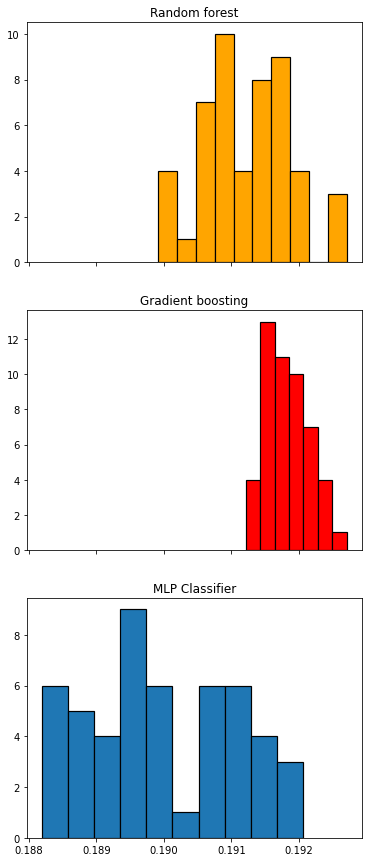

In [216]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 15))

axs[0].hist(rps_list_rf, bins=10, color="orange", edgecolor='black', linewidth=1.2)
axs[0].set_title('Random forest')

axs[1].hist(rps_list_gb, bins=7, color="red", edgecolor='black', linewidth=1.2)
axs[1].set_title('Gradient boosting')

axs[2].hist(rps_list_nn, bins=10, edgecolor='black', linewidth=1.2)
axs[2].set_title('MLP Classifier')

plt.savefig("rps_dist.png")
plt.show()

## Getting RPS from Betting site

We want to obtain the RPS for Bundesliga in 2018/2019 with betting from betting site www.betexplorer.com

In [188]:
s = requests.session()
req = s.get("https://www.betexplorer.com/soccer/germany/bundesliga-2018-2019/results/")
soup = bs(req.text, 'html.parser')

In [189]:
def get_pred_vector_norm(odds_home, odds_draw, odds_away):
    prob_home = 1 / float(odds_home)
    prob_draw = 1 / float(odds_draw)
    prob_away = 1 / float(odds_away)

    sum_of_probs = prob_home + prob_draw + prob_away

    pred_vector = [prob_home, prob_draw, prob_away]

    pred_vector_norm = [prob_home / sum_of_probs, prob_draw / sum_of_probs, prob_away / sum_of_probs]
    return pred_vector_norm

In [190]:
def get_res_vector(result):
    home, away = result.split(":")
    home, away = int(home), int(away)

    res_vector = [1, 0, 0]
    if home == away:
        res_vector = [0, 1, 0]
    elif away > home:
        res_vector = [0, 0, 1]
    
    return res_vector

In [191]:
rps_list = []
rnd = 0
rows = soup.find("table", {"class": "table-main h-mb15 js-tablebanner-t js-tablebanner-ntb"}).find_all("tr")
for row in rows:
    ths = row.find_all("th")
    if len(ths) > 0:
        rnd = int(ths[0].text.split(".")[0])
    elif rnd > 5:
        
        home, away = row.find("td", {"class": "h-text-left"}).text.split(" - ")
        
        result = row.find("td", {"class": "h-text-center"}).text
        res_vector = get_res_vector(result)
        
        probs = row.find_all("td", {"class": "table-main__odds"})
        odds_home = probs[0].get("data-odd")
        if not odds_home:
            odds_home = probs[0].find("span").find("span").find("span").get("data-odd")
            
        odds_draw = probs[1].get("data-odd")
        if not odds_draw:
            odds_draw = probs[1].find("span").find("span").find("span").get("data-odd")
            
        odds_away = probs[2].get("data-odd")
        if not odds_away:
            odds_away = probs[2].find("span").find("span").find("span").get("data-odd")
        
        pred_vector = get_pred_vector_norm(odds_home, odds_draw, odds_away)
        match_rps = rps(pred_vector, res_vector)
        rps_list.append([match_rps, rnd])

rps_df = pd.DataFrame(rps_list[::-1], columns=["RPS", "Round"])
rps_avgs = []
rnds = list(range(6, 35))
for rnd in rnds:
    rps_values = list(rps_df.loc[rps_df["Round"] == rnd, "RPS"].values)
    avg = sum(rps_values) / len(rps_values)
    rps_avgs.append(avg)
betexplorer_rps = sum(rps_avgs) / len(rps_avgs)
betexplorer_rps

0.1931014646349363

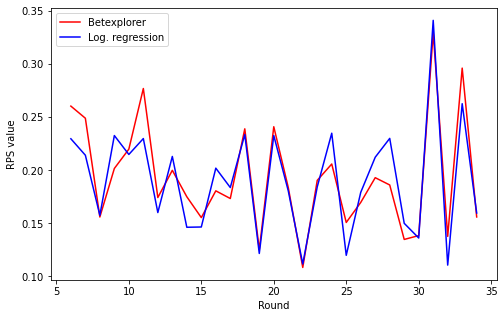

In [203]:
plt.figure(figsize=(8,5))
plt.plot(rnds, rps_avgs, color="red", label="Betexplorer")
plt.plot(rnds, rps_avgs_lr, color="blue", label="Log. regression")
plt.legend()

plt.ylabel('RPS value')
plt.xlabel('Round')
plt.savefig("bet_lr.png")
plt.show()